In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_1samp
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
ipo_ev = pd.read_sas('ipo_ev.sas7bdat')
quiet_ev = pd.read_sas('quiet_ev.sas7bdat')
seo_ev = pd.read_sas('seo_ev.sas7bdat')
added_to_sp500 = pd.read_sas('added_sp500_ev.sas7bdat')
merger_ev = pd.read_sas('merger_ev.sas7bdat')
d_mret = pd.read_sas('MKTRET_Daily.sas7bdat')
d_ret = pd.read_sas('DSF_ALL.sas7bdat')

def sasdate_to_datetime(dfs):
    dfs = pd.to_timedelta(dfs, unit='D') + pd.Timestamp('1960-1-1')
    return dfs
seo_ev.file_date_sas = sasdate_to_datetime(seo_ev.file_date_sas)
quiet_ev.quiet_period_end = sasdate_to_datetime(quiet_ev.quiet_period_end)
added_to_sp500.anndate_sas = sasdate_to_datetime(added_to_sp500.anndate_sas)
added_to_sp500.effdate_sas = sasdate_to_datetime(added_to_sp500.effdate_sas)

In [3]:
d_calc = pd.merge(pd.DataFrame(d_ret, columns=[ 'PERMNO', 'RET', 'DATE']), pd.DataFrame(d_mret, columns=['date', 'VWRETD']), left_on = "DATE", right_on = "date")
d_calc['mar'] = d_calc['RET'] - d_calc['VWRETD']
d_calc['cmar'] = d_calc.groupby(['PERMNO'])['mar'].cumsum()
d_calc

,PERMNO,RET,DATE,date,VWRETD,mar,cmar
0,10011.0,NaN,1988-06-01,1988-06-01,0.016352,NaN,NaN
1,10035.0,-0.013333,1988-06-01,1988-06-01,0.016352,-0.029686,-0.029686
2,10042.0,0.000000,1988-06-01,1988-06-01,0.016352,-0.016352,-0.016352
3,10051.0,0.000000,1988-06-01,1988-06-01,0.016352,-0.016352,-0.016352
4,10055.0,0.000000,1988-06-01,1988-06-01,0.016352,-0.016352,-0.016352
...,...,...,...,...,...,...,...
13281708,92399.0,0.000000,1986-02-05,1986-02-05,0.000850,-0.000850,4.665772
13281709,92655.0,0.009615,1986-02-05,1986-02-05,0.000850,0.008766,5.282743
13281710,92663.0,0.000000,1986-02-05,1986-02-05,0.000850,-0.000850,1.216446
13281711,93105.0,0.046296,1986-02-05,1986-02-05,0.000850,0.045447,4.523324


In [4]:
def draw_ans(df, tt):
    plt.figure(figsize = (16, 5))
    plt.title("Event:" + tt + "- CARs")
    plt.plot(df.iloc[:,0], df.iloc[:,3], linestyle= '-' , marker = 's', markerfacecolor='none')
    plt.xlabel('Day',fontsize=14)
    plt.ylabel('Average CMAR(%)',fontsize=14)
    plt.xticks(np.arange(min(df['days']), max(df['days'])+1, step=1))
    #plt.yticks(np.arange(int(min(df['acmar'])*1000)/1000, int(max(df['acmar'])*1000)/1000, step=0.001))
    plt.show()

In [20]:
def event_study(d_p, permno_p, date_p, lwindow, rwindow, graph_p, title_p):
    d_ans = pd.DataFrame(columns = ['days', 'amar', 't1', 'acmar', 't2', 'n'])
    d_ans['days'] = range(lwindow,rwindow+1)
    d_ans.loc[:,:] = 0
    d_ans['days'] = range(lwindow,rwindow+1)
    i = 0
    
    d_calc1 = pd.merge(pd.DataFrame(d_calc, columns = ['PERMNO', 'date', 'mar', 'cmar']), pd.DataFrame(d_p, columns = [permno_p, date_p]), left_on = "PERMNO", right_on = permno_p)
    d_calc1 = d_calc1.dropna()
    d_calc1['before_days'] = (d_calc1['date'] - d_calc1[date_p]).dt.days
    d_calc1['sort_num'] = d_calc1.groupby('PERMNO').cumcount()
    d_calc1['delta'] = d_calc1['before_days'] - d_calc1['sort_num']
   
    for row in d_ans.iterrows():
        d_temp = d_calc1[(d_calc1['delta'] == row[1]['days'])]
        d_ans.loc[i, 'amar'] = d_temp['mar'].dropna().mean()
        d_ans.loc[i, 'acmar'] = d_temp['cmar'].dropna().mean()
        df_bool = (d_calc1['delta'] == row[1]['days'])
        d_ans.loc[i, 'n'] = df_bool.sum()
        d_ans.loc[i, 't1'] = ttest_1samp(d_temp['mar'].dropna(), 0)[0]
        d_ans.loc[i, 't2'] = ttest_1samp(d_temp['cmar'].dropna(), 0)[0]
        i = i+1
    if(graph_p):
        draw_ans(d_ans, title_p)
    return d_ans 

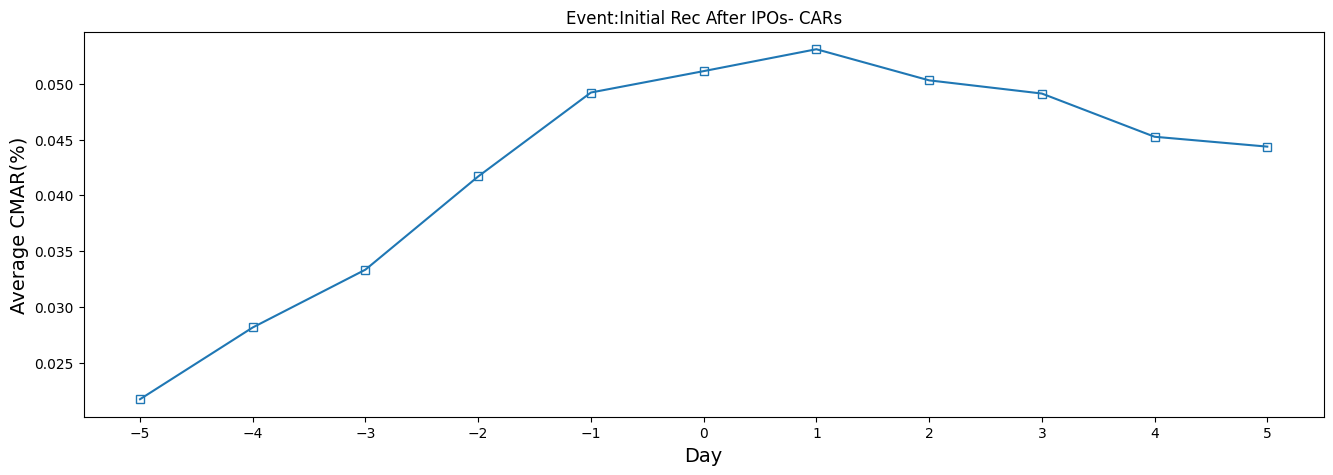

,days,amar,t1,acmar,t2,n
0,-5,0.003783,2.458766,0.021715,3.384676,1783
1,-4,0.006495,4.536367,0.028149,4.300331,1788
2,-3,0.005263,3.451931,0.033334,4.980070,1793
3,-2,0.008391,5.368550,0.041688,6.044705,1795
4,-1,0.007618,4.594188,0.049213,6.995441,1799
5,0,0.002163,1.199861,0.051131,7.117990,1808
6,1,0.001964,1.212287,0.053094,7.232657,1808
7,2,-0.002790,-1.919795,0.050304,6.598158,1808
8,3,-0.001182,-0.837685,0.049122,6.345084,1808
9,4,-0.003875,-2.700047,0.045247,5.774633,1808


In [21]:
event_study(ipo_ev, 'permno', 'RECDATS', -5, 5, 1, "Initial Rec After IPOs")

In [22]:
event_study(quiet_ev, 'permno', 'quiet_period_end', -5, 5, 0, "Quiet Periods")

IndexError: single positional indexer is out-of-bounds

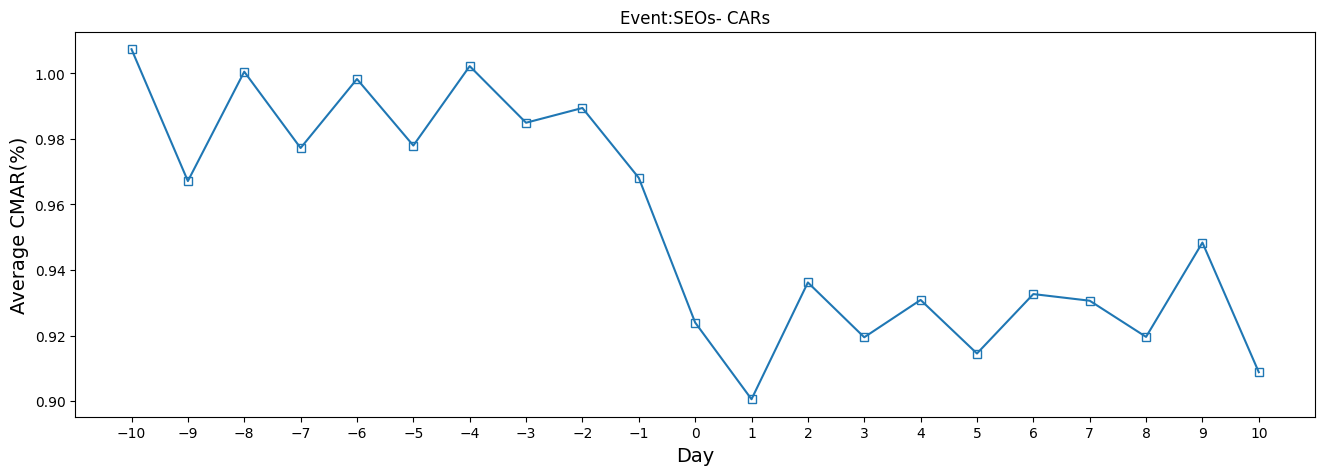

,days,amar,t1,acmar,t2,n
0,-10,0.000083,0.104417,1.007383,28.959802,2228
1,-9,0.002243,2.345131,0.967139,28.135181,1865
2,-8,-0.000853,-1.057918,1.000529,28.151521,2150
3,-7,0.001677,1.805763,0.977229,28.162428,1811
4,-6,0.001033,1.112502,0.998286,27.549644,2071
5,-5,0.000321,0.306720,0.977979,27.528556,1764
6,-4,-0.000596,-0.661740,1.002220,28.336475,2140
7,-3,-0.003194,-3.572192,0.984945,28.419168,1843
8,-2,-0.004004,-4.557979,0.989449,27.601187,2133
9,-1,-0.006073,-5.513221,0.968115,26.354478,1665


In [8]:
event_study(seo_ev, 'PERMNO', 'file_date_sas', -10, 10, 1, "SEOs")

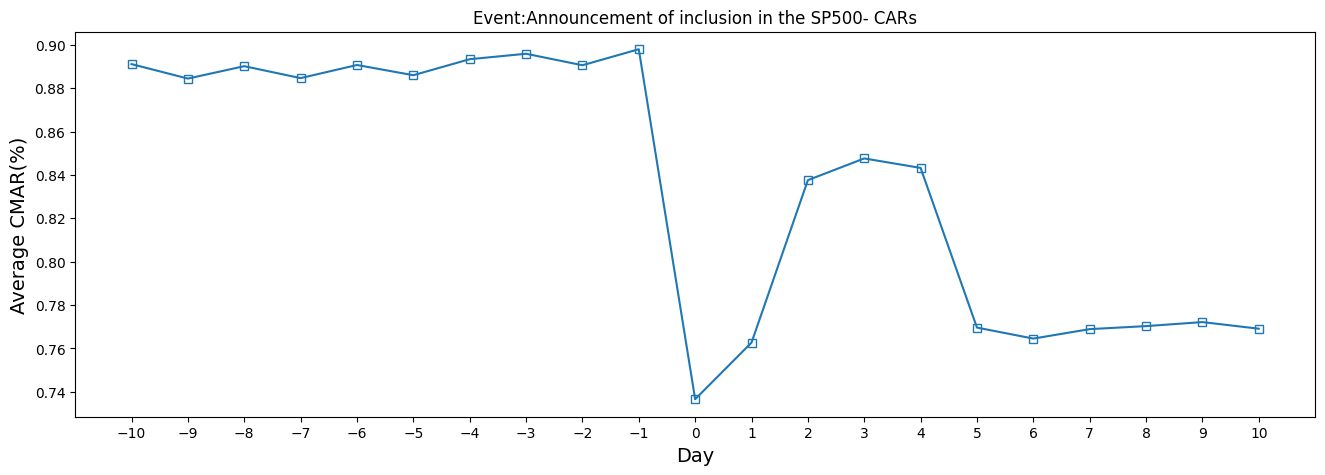

,days,amar,t1,acmar,t2,n
0,-10,0.000714,0.588299,0.891194,15.268488,560
1,-9,0.000027,0.022959,0.884516,15.256168,566
2,-8,-0.000990,-0.975656,0.890228,15.216524,560
3,-7,0.001194,1.156395,0.884731,15.255316,566
4,-6,-0.000747,-0.666368,0.890773,15.230366,560
5,-5,0.002073,1.862336,0.886065,15.270561,566
6,-4,0.000595,0.496327,0.893456,15.244223,560
7,-3,0.002510,2.308259,0.895966,15.246222,560
8,-2,0.001437,1.517970,0.890666,15.202220,564
9,-1,0.001130,0.951230,0.898059,15.252982,560


In [9]:
event_study(added_to_sp500, 'permno', 'anndate_sas',  -10, 10, 1, "Announcement of inclusion in the SP500")

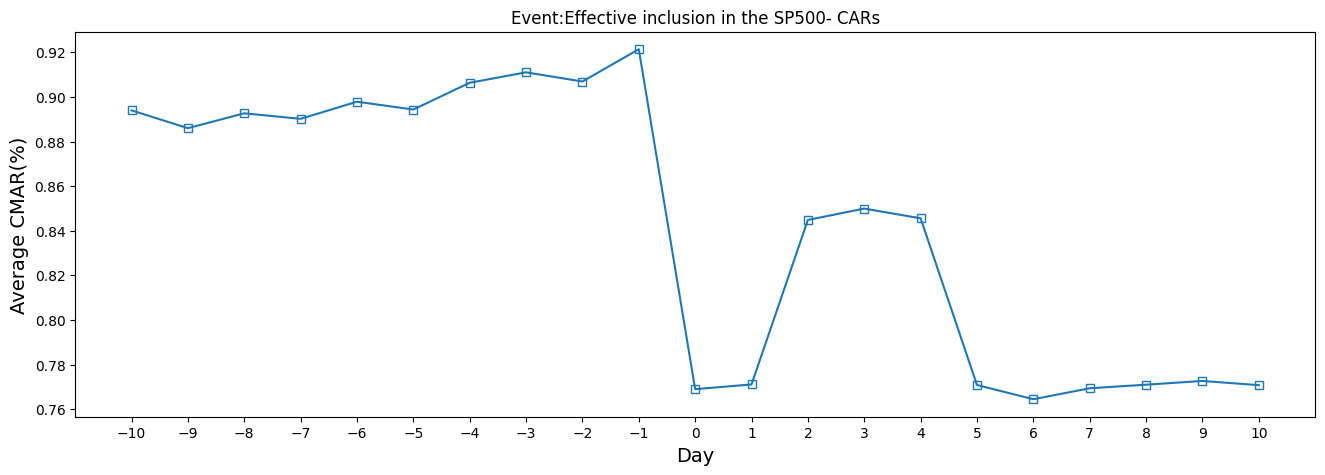

,days,amar,t1,acmar,t2,n
0,-10,0.000333,0.336610,0.893976,15.223830,560
1,-9,-0.001235,-1.186357,0.885984,15.221915,566
2,-8,-0.000039,-0.039739,0.892654,15.193518,560
3,-7,0.004705,4.152229,0.890179,15.237318,566
4,-6,0.000846,0.772937,0.897856,15.221944,560
5,-5,0.003332,2.953318,0.894348,15.303250,566
6,-4,0.005071,3.508127,0.906356,15.275495,560
7,-3,0.004673,4.001079,0.911029,15.301500,560
8,-2,0.002934,2.930008,0.906911,15.350329,566
9,-1,0.007382,5.464019,0.921396,15.428254,560


In [10]:
event_study(added_to_sp500, 'permno', 'effdate_sas',  -10, 10, 1, "Effective inclusion in the SP500")

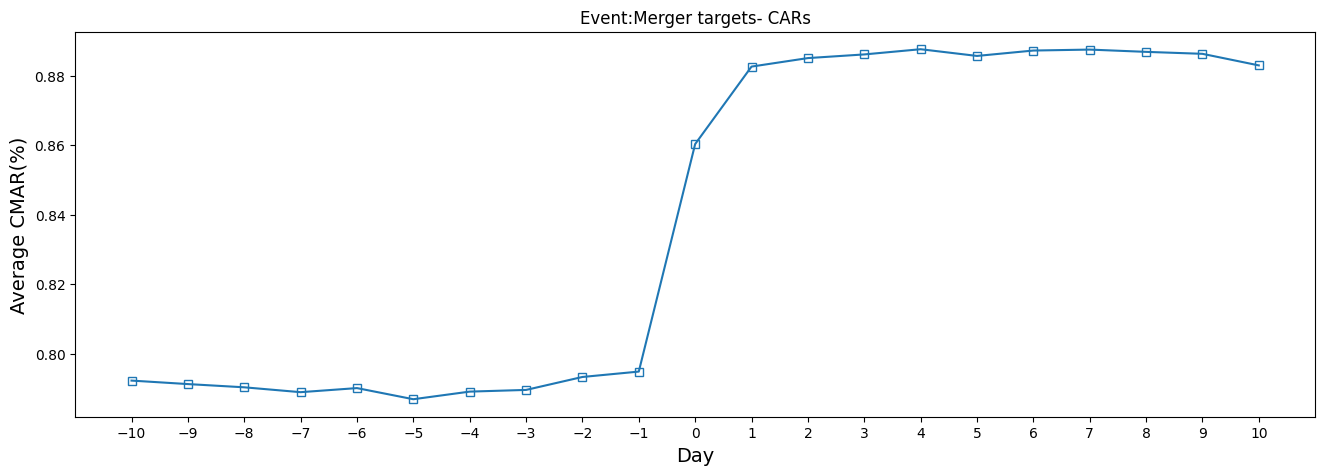

,days,amar,t1,acmar,t2,n
0,-10,-0.001394,-0.974593,0.792292,16.942447,1284
1,-9,-0.001004,-0.600861,0.791288,16.905860,1284
2,-8,-0.000930,-0.668327,0.790358,16.877295,1284
3,-7,-0.001401,-0.970542,0.788956,16.822940,1284
4,-6,0.001175,0.765600,0.790131,16.834516,1284
5,-5,-0.003203,-1.848082,0.786928,16.739390,1284
6,-4,0.002191,0.957869,0.789119,16.831543,1284
7,-3,0.000486,0.296571,0.789605,16.816316,1284
8,-2,0.003728,1.744554,0.793334,16.902014,1284
9,-1,0.001549,0.938188,0.794882,16.937278,1284


In [11]:
event_study(merger_ev, 'target_permno', 'ann_date',  -10, 10, 1, "Merger targets")